In [5]:
# Header for the notebook
from datetime import datetime
from IPython.display import display, Markdown

# Get the current date
title = "Coding Project Notebook - Circular Task"
current_date = datetime.now().strftime("%d %B %Y, %H:%M:%S")
authors = "Victor Salvat and Jin Wei Zhang (and Copilot)"

# Insert the date into the notebook
display(Markdown(f"# {title}"))
display(Markdown(f"{current_date}"))
display(Markdown(f"by {authors}"))

# Coding Project Notebook - Circular Task

22 November 2025, 15:04:50

by Victor Salvat and Jin Wei Zhang (and Copilot)

Introduction



## Table of Contents
<a id="total-title"></a>
- [1. Reproduce the graphics](#1-title)
- [2. Recompute the values](#2-title)
- [3. Test our own generated data](#3-title)
- [4. Discussion & Conclusion](#4-title)

---
<a id="1-title"></a>
# 1. [Reproduce the graphics](#total-title)

In [ ]:
# imports 
import numpy as np
import matplotlib.pyplot as plt

# install widget mode
%matplotlib widget

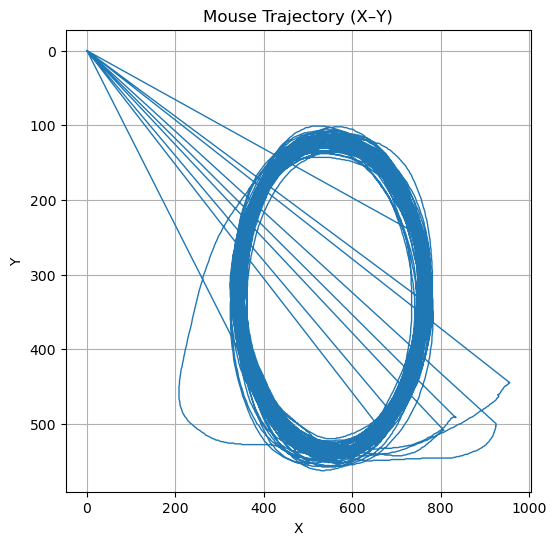

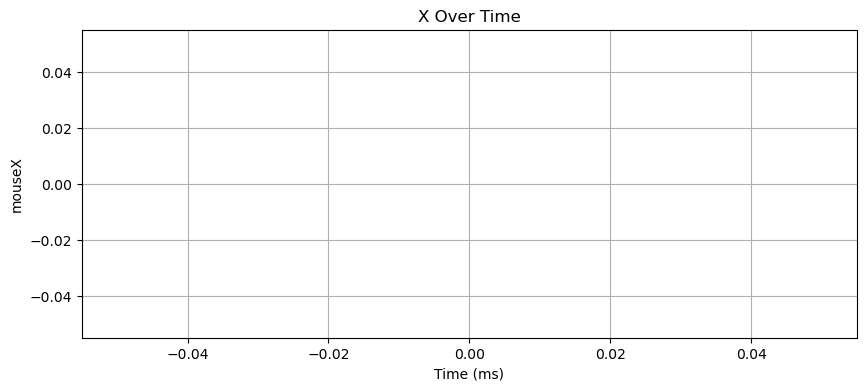

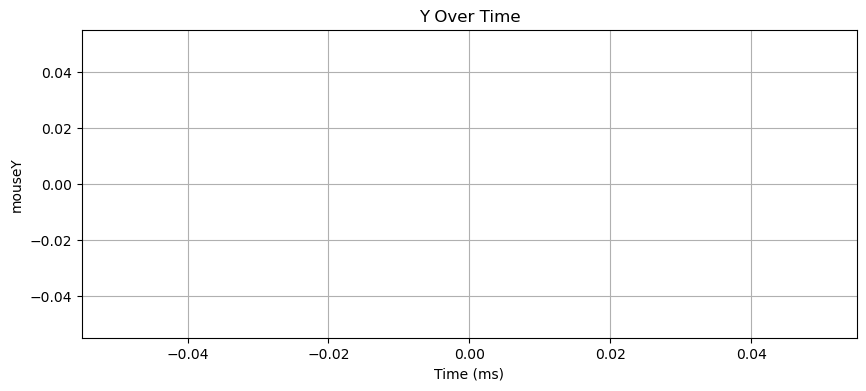

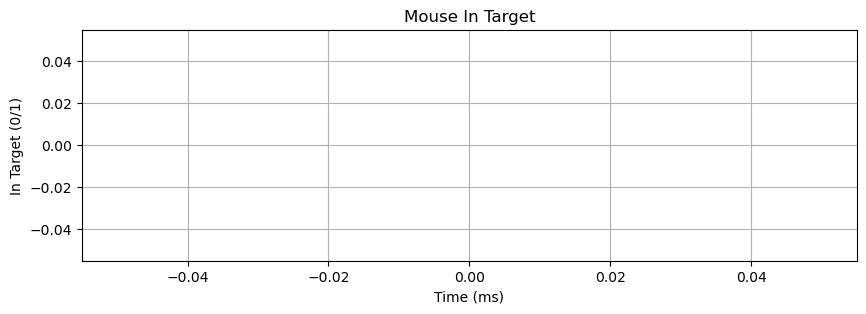

In [1]:
# -----------------------------------
# 1.1. Load libraries
# -----------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------
# 1.2. Load data (MouseReMoCo output)
# -----------------------------------
df = pd.read_csv("data/001MoDe_R1.csv", sep=";")
df.head()

# -----------------------------------
# 1.3. Clean and prepare the data
# -----------------------------------
## Convert to numeric columns
df["mouseX"] = pd.to_numeric(df["mouseX"], errors="coerce")
df["mouseY"] = pd.to_numeric(df["mouseY"], errors="coerce")
df["mouseInTarget"] = pd.to_numeric(df["mouseInTarget"], errors="coerce")

## Convert timestamp to milliseconds
df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
df["time_ms"] = (df["timestamp"] - df["timestamp"].iloc[0]) / 1e6

# -----------------------------------
# 1.4. Plot mouse trajectory (X–Y)
# -----------------------------------
plt.figure(figsize=(6,6))
plt.plot(df["mouseX"], df["mouseY"], linewidth=1)
plt.title("Mouse Trajectory (X–Y)")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# -----------------------------------
# 1.5. Plot mouse trajectory over time
# -----------------------------------
## X position vs time
plt.figure(figsize=(10,4))
plt.plot(df["time_ms"], df["mouseX"])
plt.title("X Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("mouseX")
plt.grid(True)
plt.show()

## Y position vs time
plt.figure(figsize=(10,4))
plt.plot(df["time_ms"], df["mouseY"])
plt.title("Y Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("mouseY")
plt.grid(True)
plt.show()

# Plot 'inside target' events over time
plt.figure(figsize=(10,3))
plt.plot(df["time_ms"], df["mouseInTarget"])
plt.title("Mouse In Target")
plt.xlabel("Time (ms)")
plt.ylabel("In Target (0/1)")
plt.grid(True)
plt.show()


# -----------------------------------
# 1.7. Save figures to results/
# -----------------------------------

<a id="2-title"></a>
# 2. [Recompute the values](#total-title)




<a id="3-title"></a>
# 3. [Test our own generated data](#total-title)


<a id="4-title"></a>
# 4. [Discussion & Conclusion](#total-title)

In [7]:
# Title 1
# Add your content for Title 1 here.

In [8]:
# https://nbconvert.readthedocs.io/en/latest/removing_cells.html

# https://github.com/msm1089/ipynbname/issues/17#issuecomment-1293269863


from traitlets.config import Config
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor
from IPython import get_ipython


def get_notebook_name():
    """
    Get the current notebook name (without extension).
    """
    ip = get_ipython()
    path = None
    if "__vsc_ipynb_file__" in ip.user_ns:
        path = ip.user_ns["__vsc_ipynb_file__"]

    return path.split("/")[-1].split(".")[0]


# Get the notebook name
notebook_file_name = get_notebook_name()


# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ("remove_output",)
c.TagRemovePreprocessor.remove_input_tags = ("hide",)
c.TagRemovePreprocessor.enabled = True
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

# ensure the graphics are included in the html
c.HTMLExporter.embed_images = True
# do not show the input code cells (distracts from the output)
c.HTMLExporter.exclude_output_prompt = True
c.HTMLExporter.exclude_input_prompt = True

# Configure the exporter
exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c), True)


# run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename(notebook_file_name + ".ipynb")

# Write to output html file
with open(notebook_file_name + ".html", "w") as f:
    f.write(output[0])

# open the file with the operating system
import os

# if osx use open, if linux use xdg-open, if windows use start
try:
    if os.name == "posix":
        if os.uname().sysname == "Darwin":
            # macOS
            errorCode = os.system("open " + notebook_file_name + ".html")
        else:
            # Linux
            errorCode = os.system("xdg-open " + notebook_file_name + ".html")
    elif os.name == "nt":
        # Windows
        errorCode = os.system("start " + notebook_file_name + ".html")
    else:
        print("Unsupported OS")
except Exception as e:
    print("Error opening file: ", e)